# Mémoire

In [1]:
from Basic_Model import *
from Newton import *

In [25]:
def Simulation_SquareRectangle(w1,w2,w3,w4,r1,r2,trial_type = "rr",switch_type = "Late switch", TITLE = "Insert title"):
    DELAYED_RESPONSE = 150
    Onset = 0
    Num_iter = 500
    dt = 0.001
    obj1,obj2 = newton(f,df,1e-8,1000,0,55)
    
    st1,st2 = newton(f,df,1e-8,1000,0,30)

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    xnonlin0 = np.concatenate((x0[:7],np.array([x0[8]])))
    Bruit = True
    NbreVar = 8
    
    #Define Weight Matrices
    Rnonlin = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])
    #Q = np.array([[2*w1/5+w1,0,0,-2*w1/5,0,0,w1/5-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
    #            [-2*w1/5,0,0,2*w2/5+w2,0,0,-w2/5,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
     #           [w1/5-w1,0,0,-w2/5,0,0,w1+w1/5,0],[0,0,0,-w2,0,0,0,w2]])
    
    #Define Dynamic Matrices  
    A = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    S = Q
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    #Az = (Az - np.identity(NbreVar))/dt
    #Az[8,8] = 0
    #Az[9,9] = 0

    array_L = np.zeros((Num_iter-1,2,NbreVar))    
    for k in range(Num_iter-1):
        L = np.linalg.inv(Rnonlin+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
    
    #print(array_L[0])
    #Feedback
    #Az = Az*dt + np.identity(NbreVar)
    #Az[8,8] = 0
    #Az[9,9] = 0
    #Bz = Bz*dt
    H,L,x0 = np.identity(8),array_L,xnonlin0
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2))
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = x0
    x = x0
    reelx = np.zeros(NbreVar-2)
    reelx[0] = x[0]
    reelx[1] = x[3]
    new_reelx = reelx
    sigma = np.identity(NbreVar)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat

    for k in range(Num_iter-1):
        if trial_type != "ss":
            if (switch_type == "Late switch") and ((np.sin(new_reelx[0]+new_reelx[1])*33+np.sin(new_reelx[0])*30) > 38) and Onset == 0: Onset = k
            if (switch_type == "Early switch") and ((np.sin(new_reelx[0]+new_reelx[1])*33+np.sin(new_reelx[0])*30) > 32) and Onset == 0: Onset = k

            nowX = np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30

            if trial_type == "rs" and k > DELAYED_RESPONSE + Onset:
                nowX = 0
            if trial_type == "sr" and k < DELAYED_RESPONSE + Onset:
                nowX = 0
            #print(nowX)
            solts,solte = newton(f,df,1e-8,1000,nowX,55,x0 = np.array([obj1,obj2]))

            

            #sol = solve([33*sym.cos(thetas+thetae)+30*sym.cos(thetas)-nowX,33*sym.sin(thetas+thetae)+30*sym.sin(thetas)-55],thetas,thetae)
            #print(sol[0])
            x[6] = solts
            x[7] = solte
            xhat[6] = solts
            xhat[7] = solte
            y[k][6] = solts
            y[k][7] = solte
        #print(reelx[2],array_reelx[k-1][2])
        #x[0],x[1],x[3],x[4],x[2],x[5] = reelx[0],reelx[2],reelx[1],reelx[4],(reelx[2]-array_reelx[k-1][2])/dt,(reelx[3]-array_reelx[k-1][3])/dt
        #F = np.array([0,1*0.33*np.sin(reelx[0]+reelx[1])]) if ((np.sin(new_reelx[0]+new_reelx[1])*33+np.sin(new_reelx[0])*30) > 38) else 0
    
        F2 = np.array([.8,.1])

        x[0],x[1],x[3],x[4] = reelx[0],reelx[2],reelx[1],reelx[3]        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar,1e-3)
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat - B@L[k].reshape(np.flip(B.shape))@xhat + K@(y[k]-H@xhat)
        x = A@x-B@L[k].reshape(np.flip(B.shape))@xhat+motor_noise
        v = -L[k].reshape(np.flip(B.shape))@xhat
            
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        new_reelx[0:2] += dt*reelx[2:4]
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C))
            
        M = np.array([[a1+2*a2*cos(reelx[1]),a3+a2*cos(reelx[1])],[a3+a2*cos(reelx[1]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*reelx[1])*reelx[3]/(Denominator*Denominator),
                             (a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)],
                            [(a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator),
                            (-2*a2*sin(reelx[1])*reelx[3]*Denominator+(2*a2*cos(reelx[1])+a1)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*x[5]*(2*x[1]+x[4])*sin(x[3])-a2*x[4]*(2*x[2]+x[5])*sin(x[3])
                         -a2*x[4]*x[4]*(2*x[1]+x[4])*cos(x[3]),2*x[1]*x[2]*a2*sin(x[3])+x[1]*x[1]*a2*cos(x[3])*x[4]])
        K = 1/0.06
        
    
        u = 1/K*M@v-1/K*M@Minvdot@M@np.array([x[2],x[5]])+M@np.array([x[2],x[5]])+C+Bdyn@np.array([x[1],x[4]])+1/K*Cdot+1/K*Bdyn@np.array([x[2],x[5]])
        
        new_reelx[4:6] += dt*K*(u-reelx[4:6]+F2)
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_reelx[k+1] = new_reelx.flatten()
        reelx = new_reelx    

#Plot
    x0 = xstart
    reelx = array_reelx.T[:,1:][:,::1]
    ax[U1,U2].plot(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30,color = "#2B2F42")
    if trial_type == "rs" or trial_type == "rr" or trial_type == "sr":
        PLOT_COLOR = "green"
        LABEL = "Final Rectangle\n Target"
        if trial_type == "rs":
            PLOT_COLOR = "#8D99AE"
            LABEL = "Initial Rectangle\n Target"
        ax[U1,U2].plot(np.linspace(-10,10,1000),np.ones(1000)*54,color = PLOT_COLOR, label = LABEL)
        ax[U1,U2].plot(np.linspace(-10,10,1000),np.ones(1000)*56,color = PLOT_COLOR)
    if trial_type == "ss"  or trial_type == "rs" or trial_type == "sr": 
        PLOT_COLOR = "green"
        LABEL = "Final Square\n Target"
        if trial_type == "sr":
            PLOT_COLOR = "#8D99AE"
            LABEL = "Initial Square\n Target"
        ax[U1,U2].scatter(np.cos(obj1+obj2)*33+np.cos(obj1)*30,np.sin(obj1+obj2)*33+np.sin(obj1)*30,color = PLOT_COLOR,marker = "s",label = LABEL,s = 100)
    if (trial_type == "rs" or (trial_type == "sr")) and switch_type == "Late switch": LABEL = "Force Onset &\n Late Target Switch"
    else : LABEL = "Force Onset"
    if (trial_type == "rs" or (trial_type == "sr")) and switch_type == "Early switch": 
        ax[U1,U2].plot(np.linspace(-10,10,1000),np.ones(1000)*32,linestyle = "dashdot",color = "black")
        ax[U1,U2].text(
        -9.4,
        32.5,
        "Early target switch",
        color="black",
        fontsize = 8,
        horizontalalignment="left",
        verticalalignment="center",
    )
    

    #axis = plt.gca()
    #ax[U1,U2].set_aspect('equal', adjustable='box')
    
    ax[U1,U2].set_xlabel("x [cm]")
    ax[U1,U2].set_ylabel("y [cm]")
    ax[U1,U2].grid(alpha = .4)
   
    
    ax[U1,U2].set_xlim(-10,10)
    ax[U1,U2].set_ylim(28,57)
    ax[U1,U2].set_title(TITLE,fontsize = "20")
    ax[U1,U2].plot(np.linspace(-10,10,1000),np.ones(1000)*38,linestyle = "--",color = "black")
    ax[U1,U2].text(
        -9.4,
        39,
        LABEL,
        color="black",
        fontsize = 8,
        horizontalalignment="left",
        verticalalignment="center",
    )
    
    ax[U1,U2].legend(loc = "right",fancybox=True, shadow=True)
    ax[U1,U2].spines["right"].set_visible(False)
    #ax[U1,U2].spines["left"].set_visible(False)
    ax[U1,U2].spines["top"].set_visible(False)

    
    #plt.legend()


#for perturbation in [np.array([300,150]),np.array([-300,0]),np.array([500,250]),np.array([-600,0])]: 

def Compare_Switch(w1,w2,w3,w4,r1,r2,trial_type = "rr",switch_type = "Late switch",Color = "red",plotlabel = "Insert"):
    DELAYED_RESPONSE = 150
    Onset = 0
    Num_iter = 500
    dt = 0.001
    obj1,obj2 = newton(f,df,1e-8,1000,0,55)
    
    st1,st2 = newton(f,df,1e-8,1000,0,30)

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    xnonlin0 = np.concatenate((x0[:7],np.array([x0[8]])))
    Bruit = True
    NbreVar = 8
    
    #Define Weight Matrices
    Rnonlin = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])
    #Q = np.array([[2*w1/5+w1,0,0,-2*w1/5,0,0,w1/5-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
    #            [-2*w1/5,0,0,2*w2/5+w2,0,0,-w2/5,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
     #           [w1/5-w1,0,0,-w2/5,0,0,w1+w1/5,0],[0,0,0,-w2,0,0,0,w2]])
    
    #Define Dynamic Matrices  
    A = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    S = Q
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    #Az = (Az - np.identity(NbreVar))/dt
    #Az[8,8] = 0
    #Az[9,9] = 0

    array_L = np.zeros((Num_iter-1,2,NbreVar))    
    for k in range(Num_iter-1):
        L = np.linalg.inv(Rnonlin+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
    
    #print(array_L[0])
    #Feedback
    #Az = Az*dt + np.identity(NbreVar)
    #Az[8,8] = 0
    #Az[9,9] = 0
    #Bz = Bz*dt
    H,L,x0 = np.identity(8),array_L,xnonlin0
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2))
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = x0
    x = x0
    reelx = np.zeros(NbreVar-2)
    reelx[0] = x[0]
    reelx[1] = x[3]
    new_reelx = reelx
    sigma = np.identity(NbreVar)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat

    for k in range(Num_iter-1):
        if trial_type != "ss":
            if (switch_type == "Late switch") and ((np.sin(new_reelx[0]+new_reelx[1])*33+np.sin(new_reelx[0])*30) > 38) and Onset == 0: Onset = k
            if (switch_type == "Early switch") and ((np.sin(new_reelx[0]+new_reelx[1])*33+np.sin(new_reelx[0])*30) > 32) and Onset == 0: Onset = k

            nowX = np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30

            if trial_type == "rs" and k > DELAYED_RESPONSE + Onset:
                nowX = 0
            if trial_type == "sr" and k < DELAYED_RESPONSE + Onset:
                nowX = 0
            #print(nowX)
            solts,solte = newton(f,df,1e-8,1000,nowX,55,x0 = np.array([obj1,obj2]))

            

            #sol = solve([33*sym.cos(thetas+thetae)+30*sym.cos(thetas)-nowX,33*sym.sin(thetas+thetae)+30*sym.sin(thetas)-55],thetas,thetae)
            #print(sol[0])
            x[6] = solts
            x[7] = solte
            xhat[6] = solts
            xhat[7] = solte
            y[k][6] = solts
            y[k][7] = solte
        #print(reelx[2],array_reelx[k-1][2])
        #x[0],x[1],x[3],x[4],x[2],x[5] = reelx[0],reelx[2],reelx[1],reelx[4],(reelx[2]-array_reelx[k-1][2])/dt,(reelx[3]-array_reelx[k-1][3])/dt
        #F = np.array([0,1*0.33*np.sin(reelx[0]+reelx[1])]) if ((np.sin(new_reelx[0]+new_reelx[1])*33+np.sin(new_reelx[0])*30) > 38) else 0
    
        F2 = np.array([.8,.1])

        x[0],x[1],x[3],x[4] = reelx[0],reelx[2],reelx[1],reelx[3]        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar,1e-3)
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat - B@L[k].reshape(np.flip(B.shape))@xhat + K@(y[k]-H@xhat)
        x = A@x-B@L[k].reshape(np.flip(B.shape))@xhat+motor_noise
        v = -L[k].reshape(np.flip(B.shape))@xhat
            
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        new_reelx[0:2] += dt*reelx[2:4]
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C))
            
        M = np.array([[a1+2*a2*cos(reelx[1]),a3+a2*cos(reelx[1])],[a3+a2*cos(reelx[1]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*reelx[1])*reelx[3]/(Denominator*Denominator),
                             (a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)],
                            [(a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator),
                            (-2*a2*sin(reelx[1])*reelx[3]*Denominator+(2*a2*cos(reelx[1])+a1)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*x[5]*(2*x[1]+x[4])*sin(x[3])-a2*x[4]*(2*x[2]+x[5])*sin(x[3])
                         -a2*x[4]*x[4]*(2*x[1]+x[4])*cos(x[3]),2*x[1]*x[2]*a2*sin(x[3])+x[1]*x[1]*a2*cos(x[3])*x[4]])
        K = 1/0.06
        
    
        u = 1/K*M@v-1/K*M@Minvdot@M@np.array([x[2],x[5]])+M@np.array([x[2],x[5]])+C+Bdyn@np.array([x[1],x[4]])+1/K*Cdot+1/K*Bdyn@np.array([x[2],x[5]])
        
        new_reelx[4:6] += dt*K*(u-reelx[4:6]+F2)
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_reelx[k+1] = new_reelx.flatten()
        reelx = new_reelx    

#Plot
    x0 = xstart
    reelx = array_reelx.T[:,1:][:,::1]
    ax[U1].plot(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30,color = Color,label = plotlabel)
    if switch_type == "Late switch":
        if trial_type == "rs" or trial_type == "rr" or trial_type == "sr":
            PLOT_COLOR = "green"
            LABEL = "Final Rectangle\n Target"
            if trial_type == "rs":
                PLOT_COLOR = "#8D99AE"
                LABEL = "Initial Rectangle\n Target"
            ax[U1].plot(np.linspace(-10,10,1000),np.ones(1000)*54,color = PLOT_COLOR)
            ax[U1].plot(np.linspace(-10,10,1000),np.ones(1000)*56,color = PLOT_COLOR)
        if trial_type == "ss"  or trial_type == "rs" or trial_type == "sr": 
            PLOT_COLOR = "green"
            LABEL = "Final Square\n Target"
            if trial_type == "sr":
                PLOT_COLOR = "#8D99AE"
                LABEL = "Initial Square\n Target"
            ax[U1].scatter(np.cos(obj1+obj2)*33+np.cos(obj1)*30,np.sin(obj1+obj2)*33+np.sin(obj1)*30,color = PLOT_COLOR,marker = "s",s = 100)


# Experiment

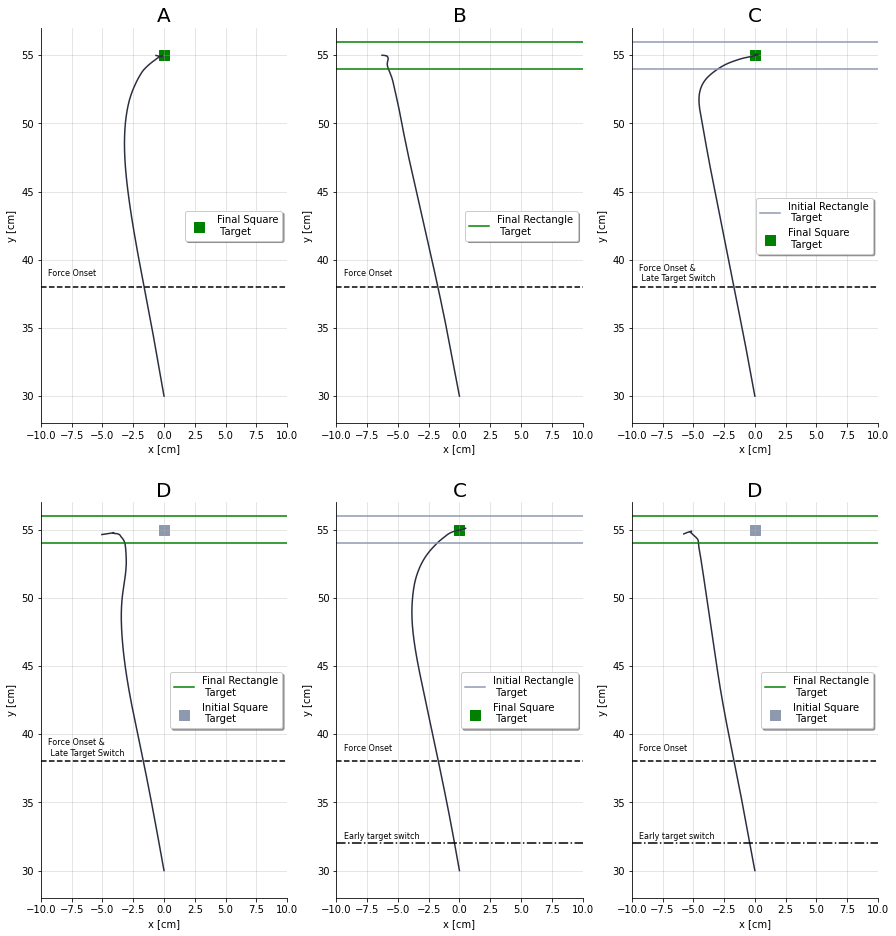

In [24]:
U1,U2 = [0,0]
fig,ax = plt.subplots(2,3,figsize = (15,16))

Simulation_SquareRectangle(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "ss",switch_type="No switch",TITLE="A")
U1,U2=[0,1]
Simulation_SquareRectangle(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "rr",switch_type="Bo switch",TITLE="B")
U1,U2=[0,2]
Simulation_SquareRectangle(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "rs",switch_type="Late switch",TITLE= "C")
U1,U2=[1,0]
Simulation_SquareRectangle(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "sr",switch_type="Late switch",TITLE= "D")
U1,U2=[1,1]
Simulation_SquareRectangle(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "rs",switch_type="Early switch",TITLE="C")
U1,U2=[1,2]
Simulation_SquareRectangle(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "sr",switch_type="Early switch",TITLE="D")
    #if perturbation[0] == 0:
    #    plt.savefig("PLOTS/nopert.pdf")
    #else : plt.savefig("PLOTS/pert.pdf")
plt.show()

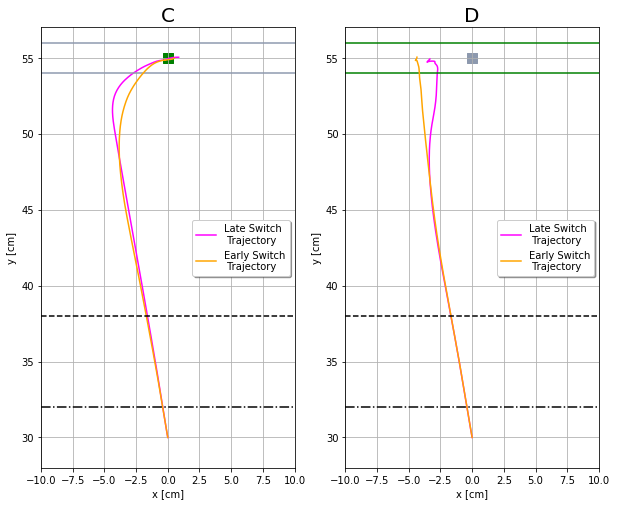

In [26]:
fig,ax = plt.subplots(1,2,figsize = (10,8.1))
Titles = ["C","D"]

U1 = 0
Compare_Switch(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "rs",switch_type="Late switch",Color = "magenta",plotlabel = "Late Switch\n Trajectory")
U1 = 1
Compare_Switch(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "sr",switch_type="Late switch",Color = "magenta",plotlabel = "Late Switch\n Trajectory")
U1 = 0
Compare_Switch(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "rs",switch_type="Early switch",Color = "orange",plotlabel = "Early Switch\n Trajectory")
U1 = 1
Compare_Switch(1e10,1e10,1e4,1e4,1e-5,1e-5,trial_type = "sr",switch_type="Early switch",Color = "orange",plotlabel = "Early Switch\n Trajectory")
for U1 in [0,1]:
    ax[U1].plot(np.linspace(-10,10,1000),np.ones(1000)*32,linestyle = "dashdot",color = "black")
    

    #axis = plt.gca()
    #ax[U1,U2].set_aspect('equal', adjustable='box')
    
    ax[U1].set_xlabel("x [cm]")
    ax[U1].set_ylabel("y [cm]")
    ax[U1].grid()
   
    
    ax[U1].set_xlim(-10,10)
    ax[U1].set_ylim(28,57)
    ax[U1].set_title(Titles[U1],fontsize = "20")
    ax[U1].plot(np.linspace(-10,10,1000),np.ones(1000)*38,linestyle = "--",color = "black")
    
    ax[U1].legend(loc = "right",fancybox=True, shadow=True)
    #if perturbation[0] == 0:
    #    plt.savefig("PLOTS/nopert.pdf")
    #else : plt.savefig("PLOTS/pert.pdf")
plt.show()

# Perturbation Approximation Validation

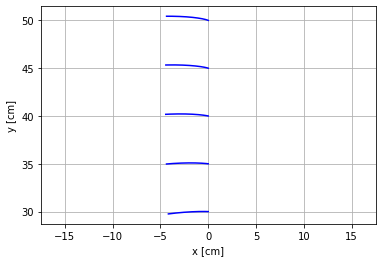

In [3]:
def Test_SquareRectangle(xobj = 30):
    Num_iter = 300
    dt = 0.001
    
    st1,st2 = newton(f,df,1e-8,1000,0,xobj)

    NbreVar = 8
    
    array_reelx = np.zeros((Num_iter,NbreVar-2))


    reelx = np.zeros(NbreVar-2)
    reelx[0] = st1
    reelx[1] = st2
    new_reelx = reelx

    for k in range(Num_iter-1):
        #print(reelx[2],array_reelx[k-1][2])
        #x[0],x[1],x[3],x[4],x[2],x[5] = reelx[0],reelx[2],reelx[1],reelx[4],(reelx[2]-array_reelx[k-1][2])/dt,(reelx[3]-array_reelx[k-1][3])/dt
        #F = np.array([0,1*0.33*np.sin(reelx[0]+reelx[1])]) if ((np.sin(new_reelx[0]+new_reelx[1])*33+np.sin(new_reelx[0])*30) > 38) else 0
        F = 0
        F2 = np.array([.8,.1])

            
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        new_reelx[0:2] += dt*reelx[2:4]
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C+F))
            
        K = 1/0.06
        

        u = 0
        
        new_reelx[4:6] += dt*K*(u-reelx[4:6]+F2)
    
        array_reelx[k+1] = new_reelx.flatten()
        reelx = new_reelx    

#Plot
    reelx = array_reelx.T[:,1:][:,::1]
    plt.plot(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30,color = "blue")
    

    #axis = plt.gca()

    #plt.ylim(xobj-2,xobj+2)


plt.axis("equal")
    
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.grid()
    
plt.xlim(-10,10)
Test_SquareRectangle(xobj = 30)
Test_SquareRectangle(xobj = 35)
Test_SquareRectangle(xobj = 40)
Test_SquareRectangle(xobj = 45)
Test_SquareRectangle(xobj = 50)